# Modeling and Predicting Crop Health Using Remote Sensing Data and Neural Networks

Azad Rasul: azad.rasul@soran.edu.iq
### Introduction
 This script performs remote sensing data analysis using raster and vector data, focusing on vegetation health assessment.
 It loads digital elevation models (DEMs) and orthophotos, calculates vegetation indices like NDVI, and classifies plots based on vegetation health.
 The classification model is a neural network built using TensorFlow, and various metrics are computed to evaluate its performance.


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#### Data Download¶
Download the GeoTIFF data from: DroneMapper Crop Analysis Data (https://github.com/dronemapper-io/CropAnalysis)
and extract it into the data/ directory of your notebook.

In [2]:
# Load raster data
# Load DEM (Digital Elevation Model), orthophoto (multi-band), and DTM (Digital Terrain Model) using rasterio
dem = rasterio.open('data/dem.tif')
ortho = rasterio.open('data/ortho.tif')
dtm = rasterio.open('data/dtm.tif')

In [3]:
# Read arrays from raster data
# Read the first band for DEM and DTM, and the first six bands for orthophoto
dem_arr = dem.read(1)
ortho_arr = ortho.read([1, 2, 3, 4, 5, 6])  # R, G, B, NIR, RedEdge, Thermal
dtm_arr = dtm.read(1)

In [4]:
# Load vector data
# Load shapefiles containing plot data
plots_1 = gpd.read_file('data/plots_1.shp')
plots_2 = gpd.read_file('data/plots_2.shp')

In [5]:
# Mask invalid data
# Set invalid elevation and thermal values to NaN
elevation = np.where(dem_arr <= 0, np.nan, dem_arr)
masked_thermal = np.where(ortho_arr[5] <= 0, np.nan, ortho_arr[5] / 100 - 273.15)  # Convert to Celsius

In [6]:
# Generate NDVI (Normalized Difference Vegetation Index) with error handling
# NDVI = (NIR - Red) / (NIR + Red)
with np.errstate(divide='ignore', invalid='ignore'):
    ndvi = (ortho_arr[3] - ortho_arr[0]) / (ortho_arr[3] + ortho_arr[0])
    ndvi = np.where(np.isnan(ndvi), 0, ndvi)

In [7]:
# Compute zonal statistics for each plot
# This function calculates the mean of the raster data within each plot geometry
def compute_zonal_stats(plots, data, affine):
    import rasterstats as rs
    plot_zs = rs.zonal_stats(plots, data, affine=affine, stats="mean", nodata=np.nan, geojson_out=True)
    return gpd.GeoDataFrame.from_features(plot_zs)

# Calculate mean NDVI, thermal, elevation, and DTM values for each plot
plots_1['NDVI_mean'] = compute_zonal_stats(plots_1, ndvi, dem.transform)['mean']
plots_1['thermal_mean'] = compute_zonal_stats(plots_1, masked_thermal, dem.transform)['mean']
plots_1['elevation_mean'] = compute_zonal_stats(plots_1, elevation, dem.transform)['mean']
plots_1['dtm_mean'] = compute_zonal_stats(plots_1, dtm_arr, dem.transform)['mean']

In [8]:
# Data preparation
# Drop NaN values and prepare feature matrix for model training
plots_1 = plots_1.dropna()
features = plots_1[['NDVI_mean', 'thermal_mean', 'elevation_mean', 'dtm_mean']]

In [9]:
# Create a synthetic target variable focusing on healthy crops
# Define healthy crops based on NDVI values between 0.4 and 0.8
healthy_mask = (plots_1['NDVI_mean'] >= 0.4) & (plots_1['NDVI_mean'] <= 0.8)
plots_1['synthetic_target'] = np.where(healthy_mask, 1, 0)  # Healthy crops = 1, Others = 0

In [10]:
# Check data balance
# Print class distribution to check for imbalance
class_counts = plots_1['synthetic_target'].value_counts()
print(f"Class distribution:\n{class_counts}")

# Handle data imbalance by undersampling the majority class
from sklearn.utils import resample

# Separate majority and minority classes
# This variable indicates whether a crop is healthy (1) or not (0).
minority_class = plots_1[plots_1['synthetic_target'] == 1]
majority_class = plots_1[plots_1['synthetic_target'] == 0]

# Resample majority class to match the minority class size
majority_class_downsampled = resample(majority_class, 
                                      replace=False, 
                                      n_samples=len(minority_class), 
                                      random_state=42)
balanced_data = pd.concat([minority_class, majority_class_downsampled])

# Reassign features and target from the balanced data
features = balanced_data[['NDVI_mean', 'thermal_mean', 'elevation_mean', 'dtm_mean']]
target = balanced_data['synthetic_target']

Class distribution:
synthetic_target
0    78
1    54
Name: count, dtype: int64


In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [12]:
# Standardize data
# Standardize features to have zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Define the neural network model
# The model has three layers: two hidden layers with dropout and an output layer with sigmoid activation for binary classification
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid activation function for binary classification
])


C:\Users\gardi\miniconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Compile the model
# Use Adam optimizer and binary crossentropy loss for compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Train the model
# Train for 100 epochs with a validation split of 20%
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.5255 - loss: 0.6803 - val_accuracy: 0.5000 - val_loss: 0.5859
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6091 - loss: 0.6049 - val_accuracy: 0.9444 - val_loss: 0.5396
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7314 - loss: 0.5460 - val_accuracy: 0.9444 - val_loss: 0.4988
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.6923 - loss: 0.5376 - val_accuracy: 1.0000 - val_loss: 0.4602
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7725 - loss: 0.4785 - val_accuracy: 1.0000 - val_loss: 0.4236
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.9095 - loss: 0.4291 - val_accuracy: 1.0000 - val_loss: 0.3906
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9511 - loss: 0.4099 - val_accuracy: 1.0000 - val_loss: 0.3618
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9203 - loss: 0.3832 - val_accuracy: 1.0000 - val_l

In [16]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9545 - loss: 0.0538
Accuracy on test data: 0.9545454382896423


In [17]:
# Make predictions
# Predict the class labels for the test set
predictions = (model.predict(X_test) > 0.5).astype("int32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


In [18]:
# Calculate evaluation metrics:
# Compute accuracy, precision, recall, F1 score, and ROC AUC score
accuracy_score_val = accuracy_score(y_test, predictions)
precision_score_val = precision_score(y_test, predictions)
recall_score_val = recall_score(y_test, predictions)
f1_score_val = f1_score(y_test, predictions)
roc_auc_score_val = roc_auc_score(y_test, model.predict(X_test))

print(f"Accuracy Score: {accuracy_score_val}")
print(f"Precision Score: {precision_score_val}")
print(f"Recall Score: {recall_score_val}")
print(f"F1 Score: {f1_score_val}")
print(f"ROC AUC Score: {roc_auc_score_val}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Accuracy Score: 0.9545454545454546
Precision Score: 1.0
Recall Score: 0.9
F1 Score: 0.9473684210526315
ROC AUC Score: 1.0


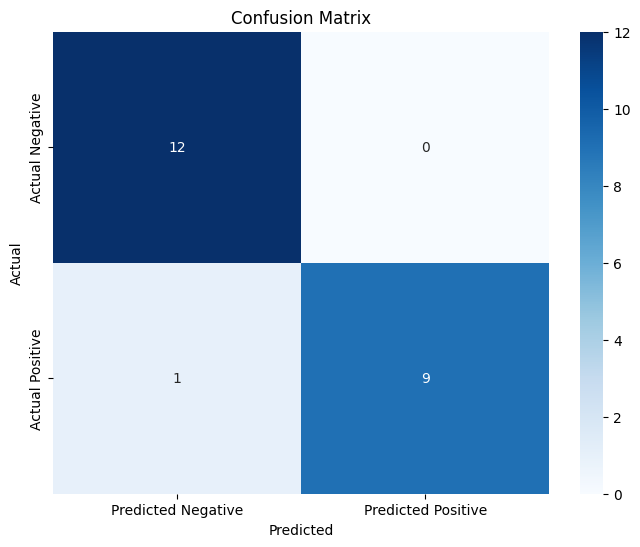

In [19]:
# Plot the confusion matrix to visualize model performance
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Conclusion
 This script demonstrates a complete workflow for processing remote sensing data, extracting relevant features, and using them for classification with a neural network.
 The model successfully distinguishes between healthy and non-healthy vegetation plots, with metrics indicating its performance.
 Future improvements could involve more advanced techniques for handling class imbalance or exploring other machine learning models.